# 05 Topic Modelling

Given that our corpus is currently not labelled, we would like to understand, based on the corpus, the distribution of terms associated in the corpus. The grouping of the terms by their likelihood of association can be obtained via the latent dirichlet allocation method. 


## Import Libraries

In [5]:
import datetime
import numpy as np
import pandas as pd
from datetime import date 

import matplotlib.pyplot as plt
import seaborn as sns

import pyLDAvis.gensim
import pyLDAvis
import pymongo 

from tqdm import tqdm

from bson.json_util import dumps

## Import Corpus

In [2]:
try:
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    client.server_info() # force connection on a request as the
                         # connect=True parameter of MongoClient seems
                         # to be useless here 
except pymongo.errors.ServerSelectionTimeoutError as err:
    # do whatever you need
    print(err)



In [3]:
db = client["parliament"]
articles = db["articles"]

In [4]:
mongo_df = pd.DataFrame.from_records(articles.find())

## Tokenise Reviews

In [8]:
mongo_df.columns

Index(['_id', 'article_text', 'cleaned_join', 'html_clean', 'parliament_num',
       'session_num', 'session_type', 'sitting_date', 'sitting_num', 'src_url',
       'title', 'volume_num'],
      dtype='object')

In [10]:
mongo_df.head()

,_id,article_text,cleaned_join,html_clean,parliament_num,session_num,session_type,sitting_date,sitting_num,src_url,title,volume_num
0,5d2340c5d46d0af6e74a4c64,<p>[(proc text) Debate resumed. (proc text)]</...,[(proc text) Debate resumed. (proc text)]<br/>...,"[[(proc text) Debate resumed. (proc text)], Mr...",13,2,SECOND READING BILLS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,PROTECTION FROM ONLINE FALSEHOODS AND MANIPULA...,94
1,5d2340c5d46d0af6e74a4c65,"<p class=""ql-align-justify"">4 <strong>Mr Vikra...",Mr Vikram Nair asked the Minister for Foreign ...,[Mr Vikram Nair asked the Minister for Foreign...,13,2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,STATE OF BILATERAL RELATIONS WITH MALAYSIA FOL...,94
2,5d2340c5d46d0af6e74a4c66,"<p class=""ql-align-justify"">8 <strong>Assoc Pr...",Assoc Prof Walter Theseira asked the Minister ...,[Assoc Prof Walter Theseira asked the Minister...,13,2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,COMPANIES WITH MEASURES TO DEAL WITH WORKPLACE...,94
3,5d2340c5d46d0af6e74a4c67,<p>5 <strong>Ms Irene Quay Siew Ching</strong>...,Ms Irene Quay Siew Ching asked the Minister fo...,[Ms Irene Quay Siew Ching asked the Minister f...,13,2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,REVIEW OF DRUG TESTING STANDARDS IN SINGAPORE ...,94
4,5d2340c5d46d0af6e74a4c68,"<p class=""ql-align-justify"">2 <strong>Mr Lim B...",Mr Lim Biow Chuan asked the Deputy Prime Minis...,[Mr Lim Biow Chuan asked the Deputy Prime Mini...,13,2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,LIVING IN PRIVATE PROPERTIES BUT WITH NO DECLA...,94


In [11]:
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
    
def get_corpus(df):
    words = list(sent_to_words(df.cleaned_join))
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

train_corpus, train_id2word, bigram_train = get_corpus(mongo_df)

/Users/syamil/anaconda3/envs/pivot/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


In [19]:
import warnings
import logging # This allows for seeing if the model converges. A log file is created.
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=10,
                           id2word=train_id2word,
                           chunksize=100,
                           workers=5, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
lda_train.save('lda_train.model')

/Users/syamil/anaconda3/envs/pivot/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/syamil/anaconda3/envs/pivot/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [9]:
from gensim.models.ldamodel import LdaModel

model = LdaModel.load('lda_train.model')

/Users/syamil/anaconda3/envs/pivot/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/syamil/anaconda3/envs/pivot/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/syamil/anaconda3/envs/pivot/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGR

In [12]:
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim.prepare(model, train_corpus, train_id2word)
pyLDAvis.display(vis)

/Users/syamil/anaconda3/envs/pivot/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [13]:
pyLDAvis.save_html(vis, 'lda.html')

## Topics Tuning

In [28]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus,
                           num_topics=num_topics,
                           id2word=train_id2word,
                           chunksize=1000,
                           workers=5, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [69]:
# run
model_list, coherence_values = compute_coherence_values(dictionary=train_id2word, 
                                                        corpus=train_corpus, texts=bigram_train, start=5, limit=40, step=2)

## Visualise Coherence Scores

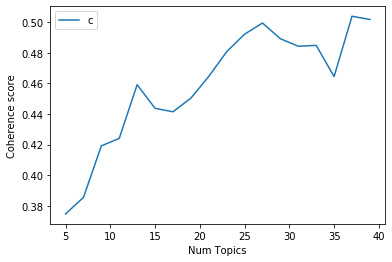

In [72]:
import matplotlib.pyplot as plt

%matplotlib inline

# Show graph
limit=40; start=5; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [37]:
from gensim.models import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_train.log_perplexity(train_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
cm = CoherenceModel(model=lda_train, corpus=train_corpus,texts=bigram_train, coherence='c_v')
coherence_lda = cm.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.480003947883418

Coherence Score:  0.4453539206402436


In [73]:
for idx, topic in lda_train.print_topics(-1, num_words=20):
    print("{}. Topic: {}  \n\t- Key Words: {}".format(idx+1, idx, (",".join(re.sub(r'\d.\d+\*','',topic).replace('"','').split('+')))))

1. Topic: 0  
	- Key Words: water , nea , public , residents , town_councils , food , ensure , town_council , ministry , areas , year , use , pub , sir , health , management , buildings , resources , measures , would
2. Topic: 1  
	- Key Words: new , companies , government , industry , help , services , support , sector , businesses , smes , business , technology , continue , develop , local , example , growth , opportunities , development , need
3. Topic: 2  
	- Key Words: saf , mas , defence , countries , asean , international , us , security , training , year , financial , foreign , region , ns , mindef , banks , china , financial_institutions , continue , investment
4. Topic: 3  
	- Key Words: students , education , schools , school , community , moe , children , support , programmes , parents , teachers , sports , learning , programme , work , arts , help , year , training , provide
5. Topic: 4  
	- Key Words: hdb , lta , new , flats , would , time , residents , public_transport ,

We see here that coherence improved greatly when the number of topics is greater than 8. Thus, the earlier assumption of having 10 topics generated via LDA is valid. Accordingly, we can label the 10 topics as follows:

1. Topic: 0 - Environment
	- Key Words: water , nea , public , residents , town_councils , food , ensure , town_council , ministry , areas
2. Topic: 1 - Business 
	- Key Words: new , companies , government , industry , help , services , support , sector , businesses , smes  
3. Topic: 2 - External Security   
	- Key Words: saf , mas , defence , countries , asean , international , us , security , training , year    
4. Topic: 3 - Education   
	- Key Words: students , education , schools , school , community , moe , children , support , programmes , parents    
5. Topic: 4 - Living   
	- Key Words: hdb , lta , new , flats , would , time , residents , public_transport , flat , year    
6. Topic: 5 - Internal Security   
	- Key Words: police , public , officers , cases , security , safety , home_affairs , number , ministry , community    
7. Topic: 6 - Healthcare   
	- Key Words: care , children , support , help , patients , health , family , need , families , singaporeans    
8. Topic: 7 - Society   
	- Key Words: people , government , one , would , singaporeans , us , think , must , need , even    
9. Topic: 8 - Employment   
	- Key Words: workers , government , help , companies , work , singaporeans , jobs , budget , employers , would    
10. Topic: 9 - Law   
	- Key Words: bill , act , would , law , case , court , legal , amendments , public , section

## Appending our Corpus with Tags!

### Finding Dominant Topic in each sentence

Using gensim's LDA topic modelling on a document

In [43]:
sent_topics_df = pd.DataFrame()

row = model[train_corpus][1]
row = sorted(row[0], key=lambda x: x[1], reverse=True)
row

[(7, 0.43655953),
 (2, 0.17807838),
 (0, 0.13052306),
 (9, 0.09896996),
 (5, 0.058110144),
 (1, 0.054801296),
 (4, 0.042660255)]

In [146]:
len(train_corpus[0])

3374

In [45]:
def format_topics_sentences(ldamodel=model, corpus=train_corpus,texts=bigram_train):
    # https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get top 3 topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=train_corpus, texts=bigram_train)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.4911,"people, government, one, would, singaporeans, ...","[proc_text, debate_resumed, proc_text, br_mr, ..."
1,1,7.0,0.4366,"people, government, one, would, singaporeans, ...","[mr_vikram, nair_asked, minister, foreign_affa..."
2,2,5.0,0.3280,"police, public, officers, cases, security, saf...","[assoc_prof, walter_theseira, asked_minister, ..."
3,3,0.0,0.2807,"water, nea, public, residents, town_councils, ...","[ms_irene, quay_siew, ching, asked_minister, h..."
4,4,7.0,0.3995,"people, government, one, would, singaporeans, ...","[mr_lim, biow_chuan, asked_deputy, prime_minis..."
5,5,6.0,0.4204,"care, children, support, help, patients, healt...","[mr_louis, ng_kok, kwang_asked, minister, heal..."
6,6,7.0,0.3054,"people, government, one, would, singaporeans, ...","[mr_png, eng_huat, asked_deputy, prime_ministe..."
7,7,8.0,0.2996,"workers, government, help, companies, work, si...","[mr_louis, ng_kok, kwang_asked, minister_manpo..."
8,8,3.0,0.5370,"students, education, schools, school, communit...","[ms_irene, quay_siew, ching, asked_minister, e..."
9,9,7.0,0.4994,"people, government, one, would, singaporeans, ...","[proc_text, resumption_debate, question, may, ..."


### LDA Inference 

#### Load Dictionary

In [15]:
from gensim.corpora.dictionary import Dictionary

In [16]:
lda_dict = Dictionary.load('lda_train.model.id2word')

In [17]:
doc_bow_sample = lda_dict.doc2bow(mongo_df.cleaned_join[1].replace('<br/>','').split()) 

In [18]:
sorted(model.get_document_topics(doc_bow_sample),key=lambda x : x[1], reverse=True)

[(7, 0.38439086),
 (2, 0.27236545),
 (0, 0.24063131),
 (9, 0.052908543),
 (4, 0.04900857)]

In [19]:
def retrieve_dominant_topic(doc, model=model ,ref_dict=lda_dict, threshold=0.1):
    doc_bow_sample = ref_dict.doc2bow(doc.split()) #input has to be a list of strings
    highest_prob = sorted(model.get_document_topics(doc_bow_sample),key=lambda x : x[1], reverse=True)[0][1]
    if highest_prob > threshold:
        topic_num = sorted(model.get_document_topics(doc_bow_sample),key=lambda x : x[1], reverse=True)[0][0]
    else:
        topic_num = 11 # no topic identidied
    
    return topic_num 

In [20]:
%time mongo_df['dominant_topic'] = mongo_df.cleaned_join.map(lambda x : retrieve_dominant_topic(x))

CPU times: user 44.8 s, sys: 3 s, total: 47.8 s
Wall time: 28.7 s


## Creating the mappings to put into our system

1. Topic: 0 - Environment
2. Topic: 1 - Business 
3. Topic: 2 - External Security   
4. Topic: 3 - Education    
5. Topic: 4 - Living   
6. Topic: 5 - Internal Security     
7. Topic: 6 - Healthcare       
8. Topic: 7 - Society       
9. Topic: 8 - Employment      
10. Topic: 9 - Law   

In [21]:
dominant_topic_mappings = {
    0 : 'Environment',
    1 : 'Business',
    2 : 'External Security',
    3 : 'Education',
    4 : 'Living',
    5 : 'Internal Security',
    6 : 'Healthcare',
    7 : 'Society',
    8 : 'Employment',
    9 : 'Law',
    11 : 'Unidentified'
}

In [22]:
mongo_df['dominant_topic'] = mongo_df['dominant_topic'].map(dominant_topic_mappings)

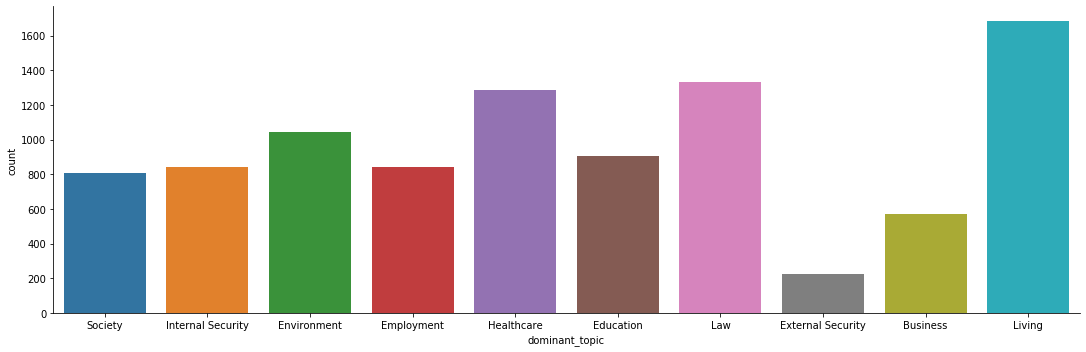

In [8]:

sns.catplot(x='dominant_topic',kind="count",data = mongo_df,height=5, aspect=3 )


In [24]:
mongo_df.head()

,_id,article_text,chunks,cleaned_join,html_clean,parliament_num,parsed_convo,persons_involved,session_num,session_type,sitting_date,sitting_num,src_url,title,volume_num,dominant_topic
0,5d27eca6172d9aa762d4802f,<p>[(proc text) Debate resumed. (proc text)]</...,"{""0"": {""entity"": ""NA"", ""content"": ""[(proc text...",[(proc text) Debate resumed. (proc text)]<br/>...,"[[(proc text) Debate resumed. (proc text)], Mr...",13,[{'content': '[(proc text) Debate resumed. (pr...,"[Mr Leon Perera, Mr K Shanmugam, Assoc Prof Wa...",2,SECOND READING BILLS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,PROTECTION FROM ONLINE FALSEHOODS AND MANIPULA...,94,Society
1,5d27eca6172d9aa762d48030,"<p class=""ql-align-justify"">4 <strong>Mr Vikra...","{""0"": {""entity"": ""NA"", ""content"": ""Mr Vikram N...",Mr Vikram Nair asked the Minister for Foreign ...,[Mr Vikram Nair asked the Minister for Foreign...,13,[{'content': 'Mr Vikram Nair asked the Ministe...,"[Dr Vivian Balakrishnan, The Minister for Fore...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,STATE OF BILATERAL RELATIONS WITH MALAYSIA FOL...,94,Society
2,5d27eca6172d9aa762d48031,"<p class=""ql-align-justify"">8 <strong>Assoc Pr...","{""0"": {""entity"": ""NA"", ""content"": ""Assoc Prof ...",Assoc Prof Walter Theseira asked the Minister ...,[Assoc Prof Walter Theseira asked the Minister...,13,[{'content': 'Assoc Prof Walter Theseira asked...,"[Ms Low Yen Ling, Ms Anthea Ong, Assoc Prof Wa...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,COMPANIES WITH MEASURES TO DEAL WITH WORKPLACE...,94,Internal Security
3,5d27eca6172d9aa762d48032,<p>5 <strong>Ms Irene Quay Siew Ching</strong>...,"{""0"": {""entity"": ""NA"", ""content"": ""Ms Irene Qu...",Ms Irene Quay Siew Ching asked the Minister fo...,[Ms Irene Quay Siew Ching asked the Minister f...,13,[{'content': 'Ms Irene Quay Siew Ching asked t...,"[The Senior Minister of State for Health, Dr L...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,REVIEW OF DRUG TESTING STANDARDS IN SINGAPORE ...,94,Environment
4,5d27eca6172d9aa762d48033,"<p class=""ql-align-justify"">2 <strong>Mr Lim B...","{""0"": {""entity"": ""NA"", ""content"": ""Mr Lim Biow...",Mr Lim Biow Chuan asked the Deputy Prime Minis...,[Mr Lim Biow Chuan asked the Deputy Prime Mini...,13,[{'content': 'Mr Lim Biow Chuan asked the Depu...,"[Ms Indranee Rajah, The Second Minister for Fi...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,LIVING IN PRIVATE PROPERTIES BUT WITH NO DECLA...,94,Employment


In [25]:
mongo_df._id[0]

ObjectId('5d27eca6172d9aa762d4802f')

In [73]:
query = { "_id": mongo_df['_id'][0] }
value = { "$set": { "dominant_topic": mongo_df['dominant_topic'][0] } }


articles.update_one(query,value)

In [27]:
from tqdm import tqdm

for row in tqdm(mongo_df.itertuples()):
    query = { "_id" : row._1 }
    value = { "$set": { "dominant_topic": row.dominant_topic } }
    articles.update_one(query,value)

9531it [00:16, 584.68it/s]
